<a href="https://colab.research.google.com/github/urazkagangunes/pneumoniaDetectionUsingDeepLearning/blob/main/Derin_%C3%96%C4%9Frenme_ile_Zat%C3%BCrre_Tespiti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Derin Öğrenme ile Zatürre Tespiti (Pneumonia Detection with Deep Learning)**

# Kütüphaneler Eklendi

Bu kod, gerekli kütüphaneleri içe aktarır. Görüntü işleme, veri analizi ve makine öğrenimi için kullanılan kütüphaneler arasında OpenCV, Pandas, NumPy, Matplotlib, Seaborn, TensorFlow ve Keras bulunur. Ayrıca, model değerlendirme için sklearn ve görsel stil ayarları için Seaborn kullanılır.

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
from pathlib import Path
import os
from PIL import Image
import itertools

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# Veri Yolunun İndirilmesi ve Ayarlanması




Kaggle üzerinden veri seti çekiliyor.

In [ ]:
print('Modules Loaded')
od.download("https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia")
path = Path("chest-xray-pneumonia/chest_xray/chest_xray/")

Modules Loaded
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: urazkagangunes
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


# Eğitim Veri Kümesi için Veri Hazırlama

Bu kod, zatürre tespiti modeli için eğitim verilerini hazırlar. Eğitim verisi klasöründeki görsel dosyalarını okur, her birinin yolunu ve etiketini (örneğin, "NORMAL" veya "PNEUMONIA") bir Pandas DataFrame'inde depolar. Kod, klasörleri ve dosyaları iteratif olarak dolaşıp, dosya yollarını ve etiketleri toplar ve bunları bir DataFrame'e ekler.

In [ ]:
train_data_path = path / 'train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    foldpath = os.path.join(train_data_path, fold)
    # Check if the current item is a directory before attempting to list its contents.
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)

        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
df

,filepaths,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tra...,PNEUMONIA
1,chest-xray-pneumonia/chest_xray/chest_xray/tra...,PNEUMONIA
2,chest-xray-pneumonia/chest_xray/chest_xray/tra...,PNEUMONIA
3,chest-xray-pneumonia/chest_xray/chest_xray/tra...,PNEUMONIA
4,chest-xray-pneumonia/chest_xray/chest_xray/tra...,PNEUMONIA
...,...,...
5213,chest-xray-pneumonia/chest_xray/chest_xray/tra...,NORMAL
5214,chest-xray-pneumonia/chest_xray/chest_xray/tra...,NORMAL
5215,chest-xray-pneumonia/chest_xray/chest_xray/tra...,NORMAL
5216,chest-xray-pneumonia/chest_xray/chest_xray/tra...,NORMAL


# Validation Veri Kümesi için Veri Hazırlama

Bu kod, doğrulama veri setini hazırlar. "val" klasöründeki görsellerin dosya yollarını ve etiketlerini (örneğin, "NORMAL" veya "PNEUMONIA") bir listeye ekler. Bu bilgiler daha sonra Pandas DataFrame'inde birleştirilerek doğrulama veri seti oluşturulur.

In [ ]:
valid_data_dir = path / 'val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    # Check if the current item is a directory before attempting to list its contents.
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)

        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
valid

,filepaths,label
0,chest-xray-pneumonia/chest_xray/chest_xray/val...,PNEUMONIA
1,chest-xray-pneumonia/chest_xray/chest_xray/val...,PNEUMONIA
2,chest-xray-pneumonia/chest_xray/chest_xray/val...,PNEUMONIA
3,chest-xray-pneumonia/chest_xray/chest_xray/val...,PNEUMONIA
4,chest-xray-pneumonia/chest_xray/chest_xray/val...,PNEUMONIA
5,chest-xray-pneumonia/chest_xray/chest_xray/val...,PNEUMONIA
6,chest-xray-pneumonia/chest_xray/chest_xray/val...,PNEUMONIA
7,chest-xray-pneumonia/chest_xray/chest_xray/val...,PNEUMONIA
8,chest-xray-pneumonia/chest_xray/chest_xray/val...,PNEUMONIA
9,chest-xray-pneumonia/chest_xray/chest_xray/val...,NORMAL


# Test Veri Kümesi için Veri Hazırlama

Bu kod, test veri setini hazırlar. "test" klasöründeki görsellerin dosya yollarını ve etiketlerini (örneğin, "NORMAL" veya "PNEUMONIA") bir listeye ekler. Bu bilgiler, Pandas DataFrame'ine aktarılır ve test veri seti oluşturulur.

In [ ]:
test_data_dir = path / 'test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    # Check if the current item is a directory before attempting to list its contents.
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)

        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
test

,filepaths,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tes...,PNEUMONIA
1,chest-xray-pneumonia/chest_xray/chest_xray/tes...,PNEUMONIA
2,chest-xray-pneumonia/chest_xray/chest_xray/tes...,PNEUMONIA
3,chest-xray-pneumonia/chest_xray/chest_xray/tes...,PNEUMONIA
4,chest-xray-pneumonia/chest_xray/chest_xray/tes...,PNEUMONIA
...,...,...
619,chest-xray-pneumonia/chest_xray/chest_xray/tes...,NORMAL
620,chest-xray-pneumonia/chest_xray/chest_xray/tes...,NORMAL
621,chest-xray-pneumonia/chest_xray/chest_xray/tes...,NORMAL
622,chest-xray-pneumonia/chest_xray/chest_xray/tes...,NORMAL


# Verileri Eğitim, Geçerli, Test Olarak Bölme

Bu iki satır, veri setini üçe ayırır: %80 eğitim, %10 doğrulama, %10 test. İlk satır, train_test_split fonksiyonunu kullanarak eğitim verisini ayırır. İkinci satır, kalan %20'yi doğrulama ve test verisine böler. Veri karıştırılır ve aynı şekilde bölünmesi için random_state kullanılır.

In [ ]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

# Görüntü Veri Üreticisi (Image Data Generator) ve Veri Yükleme

Bu kod, görüntü verilerini yüklemek ve ön işleme yapmak için veri jeneratörleri oluşturur. Görüntüler 224x224 boyutlarına yeniden boyutlandırılır ve her batch'te 4 resim işlenir. Eğitim, doğrulama ve test verileri, flow_from_dataframe ile DataFrame'den yüklenir. Etiketler kategorik olarak işlenir ve veriler, eğitimde karıştırılır, testte ise sabit tutulur.

In [ ]:
# crobed image size
batch_size = 4
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size,  prefetch=tf.data.AUTOTUNE )

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size,  prefetch=tf.data.AUTOTUNE )

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size,  prefetch=tf.data.AUTOTUNE )

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


# Verilerden Örnek Gösterme

Bu kod, eğitim veri setinden 8 örnek görüntüyü alır ve etiketleriyle birlikte matplotlib ile görselleştirir. İlk olarak sınıf isimlerini alır, ardından 8 görüntü ve etiketini toplar. Son olarak, her bir görüntüyü 4x4 gridde gösterir ve her görüntünün başlığına etiketini ekler.

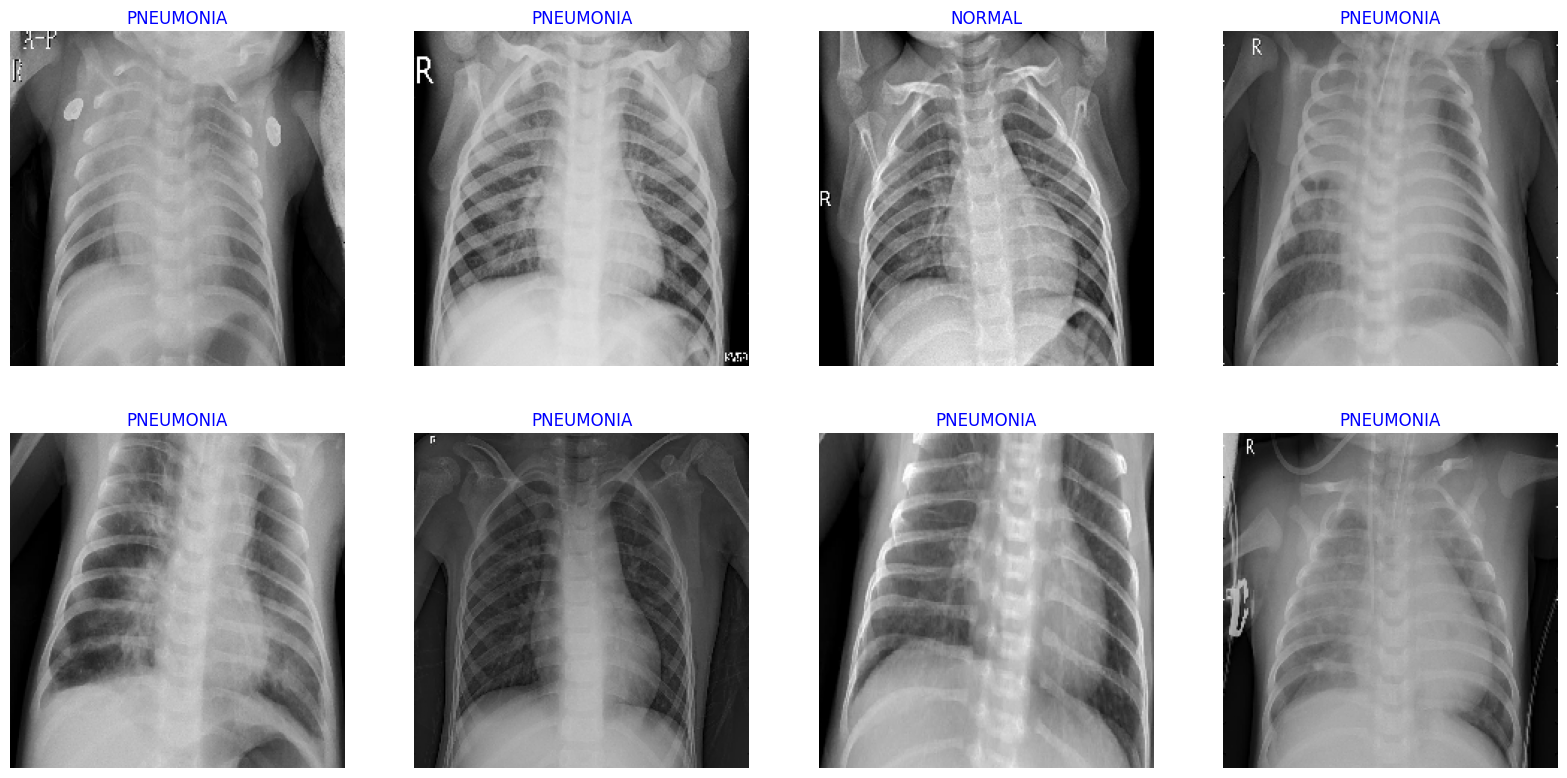

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())

# Fetch enough images for 8 samples
images, labels = [], []
while len(images) < 8:
    batch_images, batch_labels = next(train_gen)
    images.extend(batch_images)
    labels.extend(batch_labels)

plt.figure(figsize=(20, 20))

for i in range(8):  # Display 8 images
    plt.subplot(4, 4, i + 1)  # 3x3 grid
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()

# Veri Dağılımının Çizelgesi

Bu kod, eğitim veri setindeki "NORMAL" ve "PNEUMONIA" sınıflarının dağılımını görselleştiren bir pasta grafiği oluşturur. İlk olarak her sınıfın sayısı hesaplanır, ardından bu sayılarla pasta grafiği çizilir ve sınıflar renkli etiketlerle gösterilir. Bu grafik, veri setindeki sınıf dengesini görsel olarak sunar.

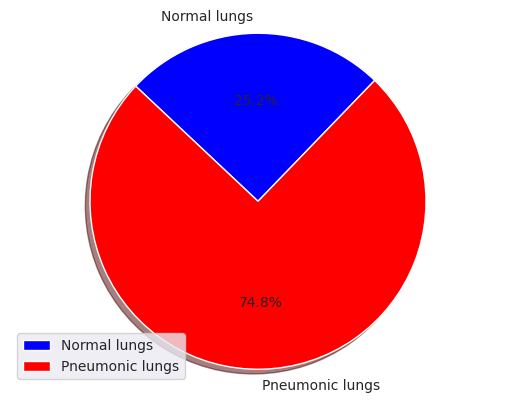

In [ ]:
fig1,ax1= plt.subplots()

# Calculate the counts of 'NORMAL' and 'PNEUMONIA' from your train_df DataFrame
train_normal_count = len(train_df[train_df['label'] == 'NORMAL'])
train_pneumonia_count = len(train_df[train_df['label'] == 'PNEUMONIA'])

sizes=[train_normal_count, train_pneumonia_count]
ax1.pie(sizes, startangle=46 ,labels=["Normal lungs","Pneumonic lungs"], autopct="%1.1f%%", shadow=True, colors=["b","r"])
ax1.axis("equal")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Case Distribution')

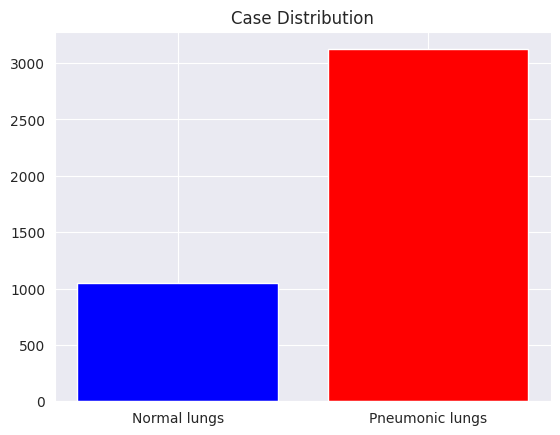

In [ ]:
fig2, ax2=plt.subplots()
ax2.bar(height=sizes, x=["Normal lungs", "Pneumonic lungs"], color=["blue", "red"])
plt.title("Case Distribution")

# Model Yapısı

Bu kod, Keras ile bir Konvolüsyonel Sinir Ağı (CNN) modeli tanımlar, derler ve özetini yazdırır. Model, zatürre tespiti için sınıflandırma yapar.

Girdi boyutları 224x224 piksel ve 3 renk kanalından oluşan görüntülerdir. class_count ile sınıf sayısı belirlenir.

Model, Adamax optimizasyon algoritması ve categorical_crossentropy kayıp fonksiyonu ile derlenir. accuracy metriği, doğruluğu ölçer. model.summary() ise modelin özetini verir.

Bu kod, modelin yapısını tanımlar ve eğitim sürecinde kullanılacak yapılandırmaları ayarlar.

Sequential model, katmanların sırasıyla eklenmesini sağlar.

İlk katmanlar, görüntülerden özellikleri çıkaran konvolüsyonel katmanlardır (Conv2D).

Ardından, MaxPooling2D katmanı, özellik haritalarının boyutlarını küçültür.

Flatten katmanı, çok boyutlu verileri tek boyutlu hale getirir.

Dense katmanları, modelin öğrenmesini sağlayan tam bağlı katmanlardır. Son katman, sınıf sayısı kadar nöron içerir ve softmax aktivasyon fonksiyonu kullanarak sınıf olasılıkları üretir.

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         401,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 530,114 (2.02 MB)

 Trainable params: 530,114 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

# Modelin Eğitilmesi

Bu kod, modelin eğitimini başlatır. epochs değeri 13 olarak ayarlanır, bu da modelin 13 kez tüm eğitim verisinden öğrenmesi anlamına gelir. model.fit fonksiyonu, eğitim verisiyle (train_gen) modeli eğitir, her epoch sonrası doğrulama verisiyle (valid_gen) modelin başarımını test eder. verbose=1, eğitim sürecinin her epoch'ta ilerlemesini gösterir. history, eğitim ve doğrulama sonuçlarını kaydeder.

In [ ]:
epochs = 13   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/13
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 988s 942ms/step - accuracy: 0.8472 - loss: 0.3698 - val_accuracy: 0.9540 - val_loss: 0.1269
Epoch 2/13
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 914s 876ms/step - accuracy: 0.9585 - loss: 0.1122 - val_accuracy: 0.9636 - val_loss: 0.1016
Epoch 3/13
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 934s 895ms/step - accuracy: 0.9652 - loss: 0.0912 - val_accuracy: 0.9195 - val_loss: 0.1930
Epoch 4/13
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 952s 912ms/step - accuracy: 0.9658 - loss: 0.0923 - val_accuracy: 0.9693 - val_loss: 0.1043
Epoch 5/13
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 926s 888ms/step - accuracy: 0.9759 - loss: 0.0600 - val_accuracy: 0.9636 - val_loss: 0.0900
Epoch 6/13
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 920s 882ms/step - accuracy: 0.9821 - loss: 0.0496 - val_accuracy: 0.9655 - val_loss: 0.1187
Epoch 7/13
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 923s 885ms/step - accuracy: 0.9830 - loss: 0.0406 - val_accuracy: 0.9732 - val_loss: 0.0752
Epoch 8/13
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 920s 882ms/step - ac

# Eğitim Geçmişini Görselleştirme

Bu kod, modelin eğitim geçmişini görselleştirir. Eğitim doğruluğu ve kaybı ile doğrulama doğruluğu ve kaybı değerlerini çıkararak, her epoch için grafikler oluşturur. En iyi epoch'ları (en düşük doğrulama kaybı ve en yüksek doğrulama doğruluğu) belirler ve bunları grafiklerde vurgular. İki alt grafik (kaybı ve doğruluğu) oluşturur, her birine eğitim ve doğrulama verileri ile en iyi epoch noktalarını ekler. Bu, modelin eğitim sürecini analiz etmeyi sağlar.

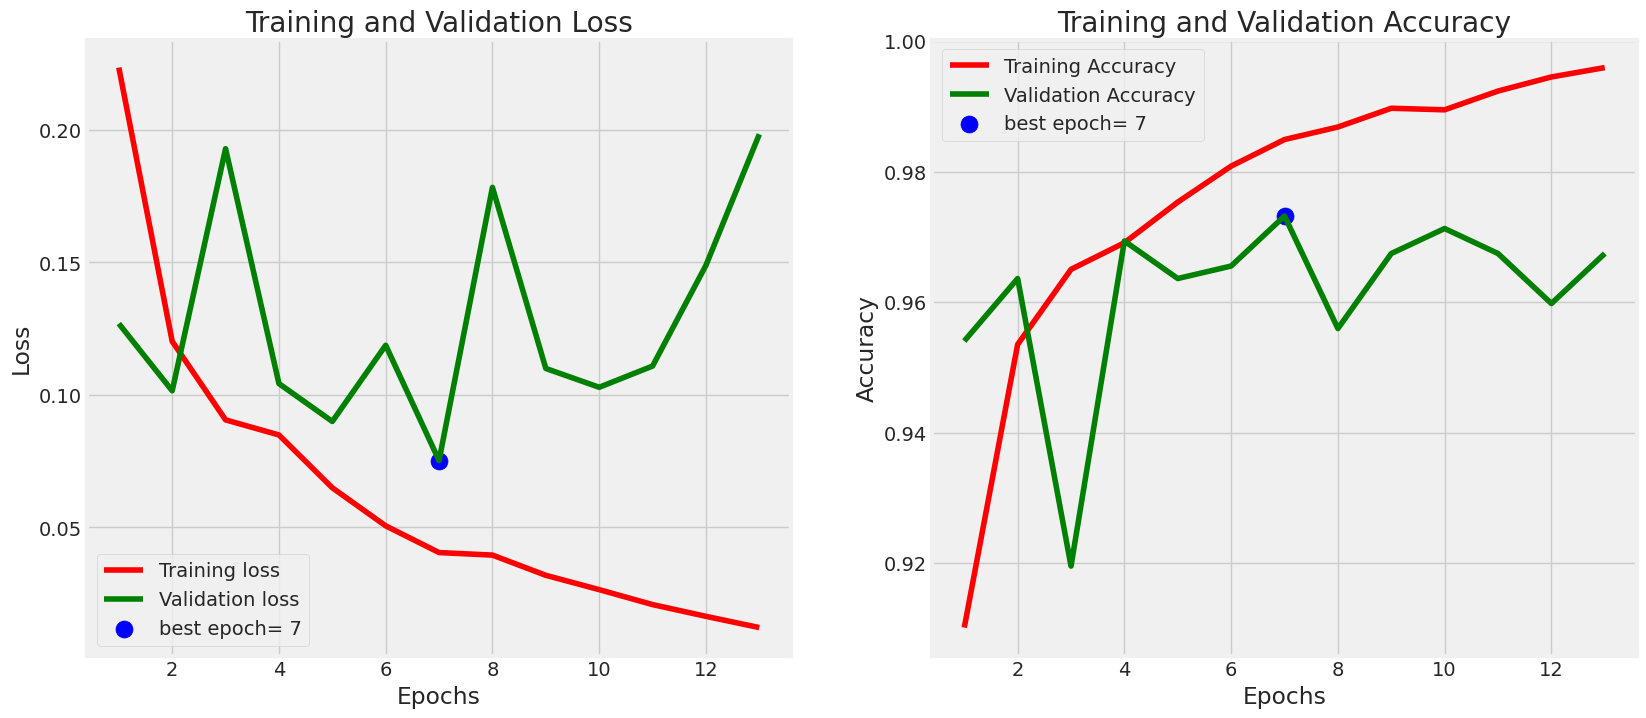

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Model Değerlendirme

Bu kod, eğitim, doğrulama ve test verileri üzerinde modelin performansını değerlendirir. model.evaluate() fonksiyonu ile her bir veri kümesi için kayıp ve doğruluk değerleri hesaplanır. Ardından bu sonuçlar, kayıp ve doğruluk değerleriyle birlikte ekrana yazdırılır. Bu işlem, modelin yeni verilere nasıl genelleme yaptığını değerlendirmeyi sağlar.

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1043/1043 ━━━━━━━━━━━━━━━━━━━━ 234s 224ms/step - accuracy: 0.9977 - loss: 0.0055
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 223ms/step - accuracy: 0.9653 - loss: 0.2009
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 228ms/step - accuracy: 0.9802 - loss: 0.0788
Train Loss:  0.007677972316741943
Train Accuracy:  0.9976030588150024
--------------------
Validation Loss:  0.19839701056480408
Validation Accuracy:  0.967432975769043
--------------------
Test Loss:  0.10645490884780884
Test Accuracy:  0.975095808506012


Bu kod, test verisi üzerinde modelin tahminler yapmasını sağlar. model.predict() fonksiyonu ile test verisi üzerinde tahminler yapılır ve bu tahminler, en yüksek olasılığı olan sınıf etiketiyle y_pred değişkenine dönüştürülür.

In [ ]:
preds = model.predict(test_gen) # Use model.predict instead of model.predict_generator
y_pred = np.argmax(preds, axis=1)

131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 229ms/step


Bu kod, modelin tahmin performansını değerlendiren bir karışıklık matrisini (confusion matrix) hesaplar ve görselleştirir. Gerçek ve tahmin edilen etiketler karşılaştırılır, matris oluşturulur ve sınıflar arasındaki hatalar renkli bir şekilde görselleştirilir.

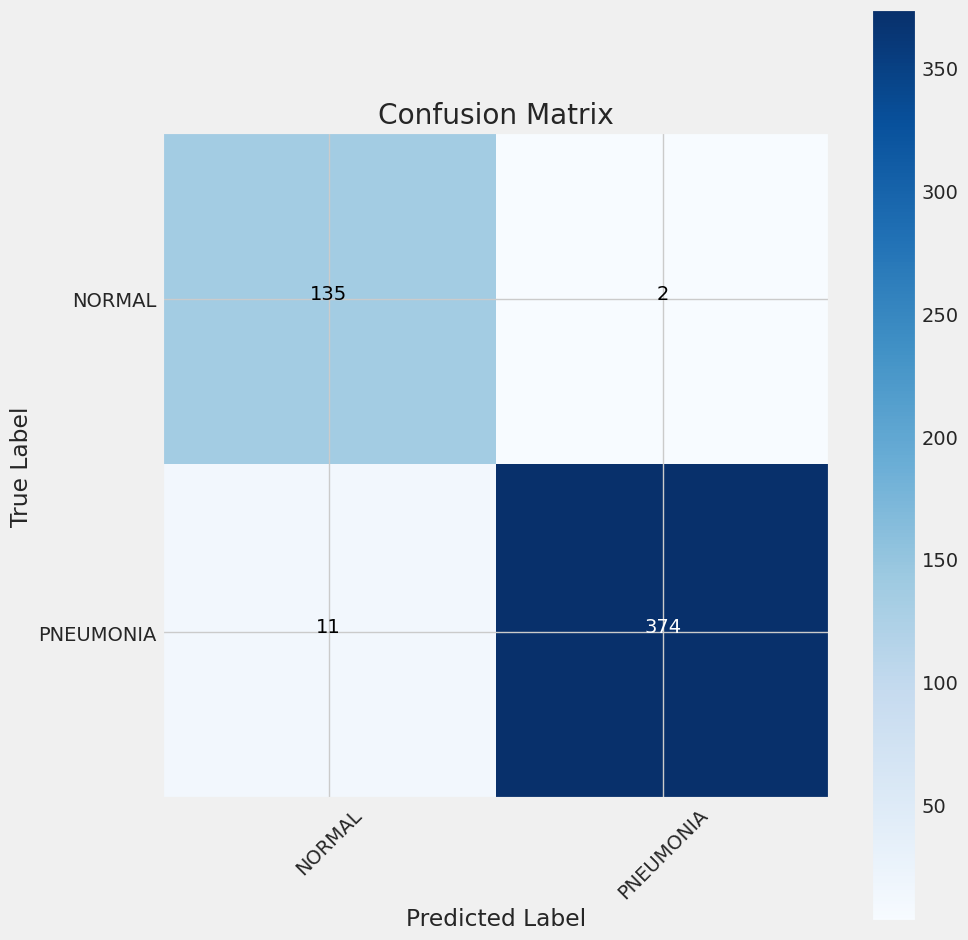

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Bu kod, modelin test verisi üzerindeki performansını değerlendiren bir sınıflandırma raporu oluşturur. Gerçek etiketler (test_gen.classes) ve tahmin edilen etiketler (y_pred) arasındaki doğruluk, precision, recall, F1 skoru gibi metrikleri hesaplar ve rapor olarak yazdırır.

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.92      0.99      0.95       137
   PNEUMONIA       0.99      0.97      0.98       385

    accuracy                           0.98       522
   macro avg       0.96      0.98      0.97       522
weighted avg       0.98      0.98      0.98       522



ROC Eğrisi Değerlendirmesi

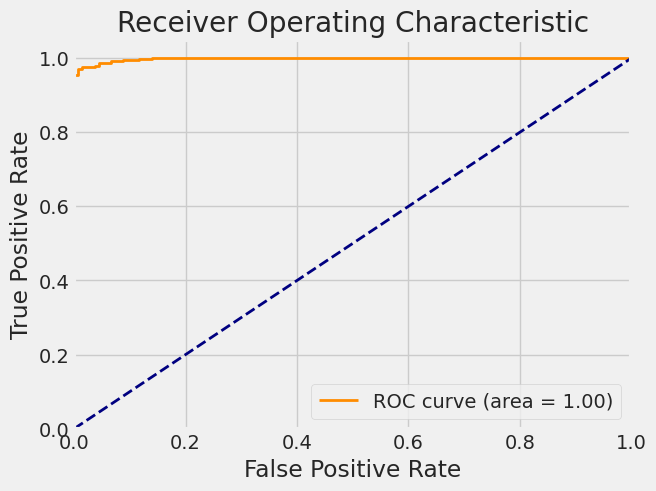

In [ ]:
# ROC eğrisi için olasılıkları alın (sadece pozitif sınıf için)
y_probs = preds[:, 1]  # İkinci sütun, pozitif sınıfın olasılığını temsil eder

# ROC eğrisini hesaplayın
fpr, tpr, thresholds = roc_curve(test_gen.classes, y_probs)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizdirin
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Doğru ve Yanlış Sınıflandırılmış Görüntüleri Görselleştirme

Bu kod, modelin doğru ve yanlış sınıflandırdığı görüntülerin indekslerini bulur. correct doğru sınıflandırılanları, incorrect ise yanlış sınıflandırılanları içerir. Bu indeksler, modelin performansını analiz etmek için kullanılabilir.

In [ ]:
correct = np.nonzero(y_pred == test_gen.classes)[0]
incorrect = np.nonzero(y_pred != test_gen.classes)[0]

Bu kod, modelin doğru sınıflandırdığı 6 görüntüyü görselleştirir. Her görüntü, doğru ve tahmin edilen etiketleriyle birlikte 3x3 bir ızgarada gösterilir. Görüntüler normalleştirilir ve başlıklar, tahmin ve gerçek sınıflandırmalarla etiketlenir.
Bazı doğru tahminler:

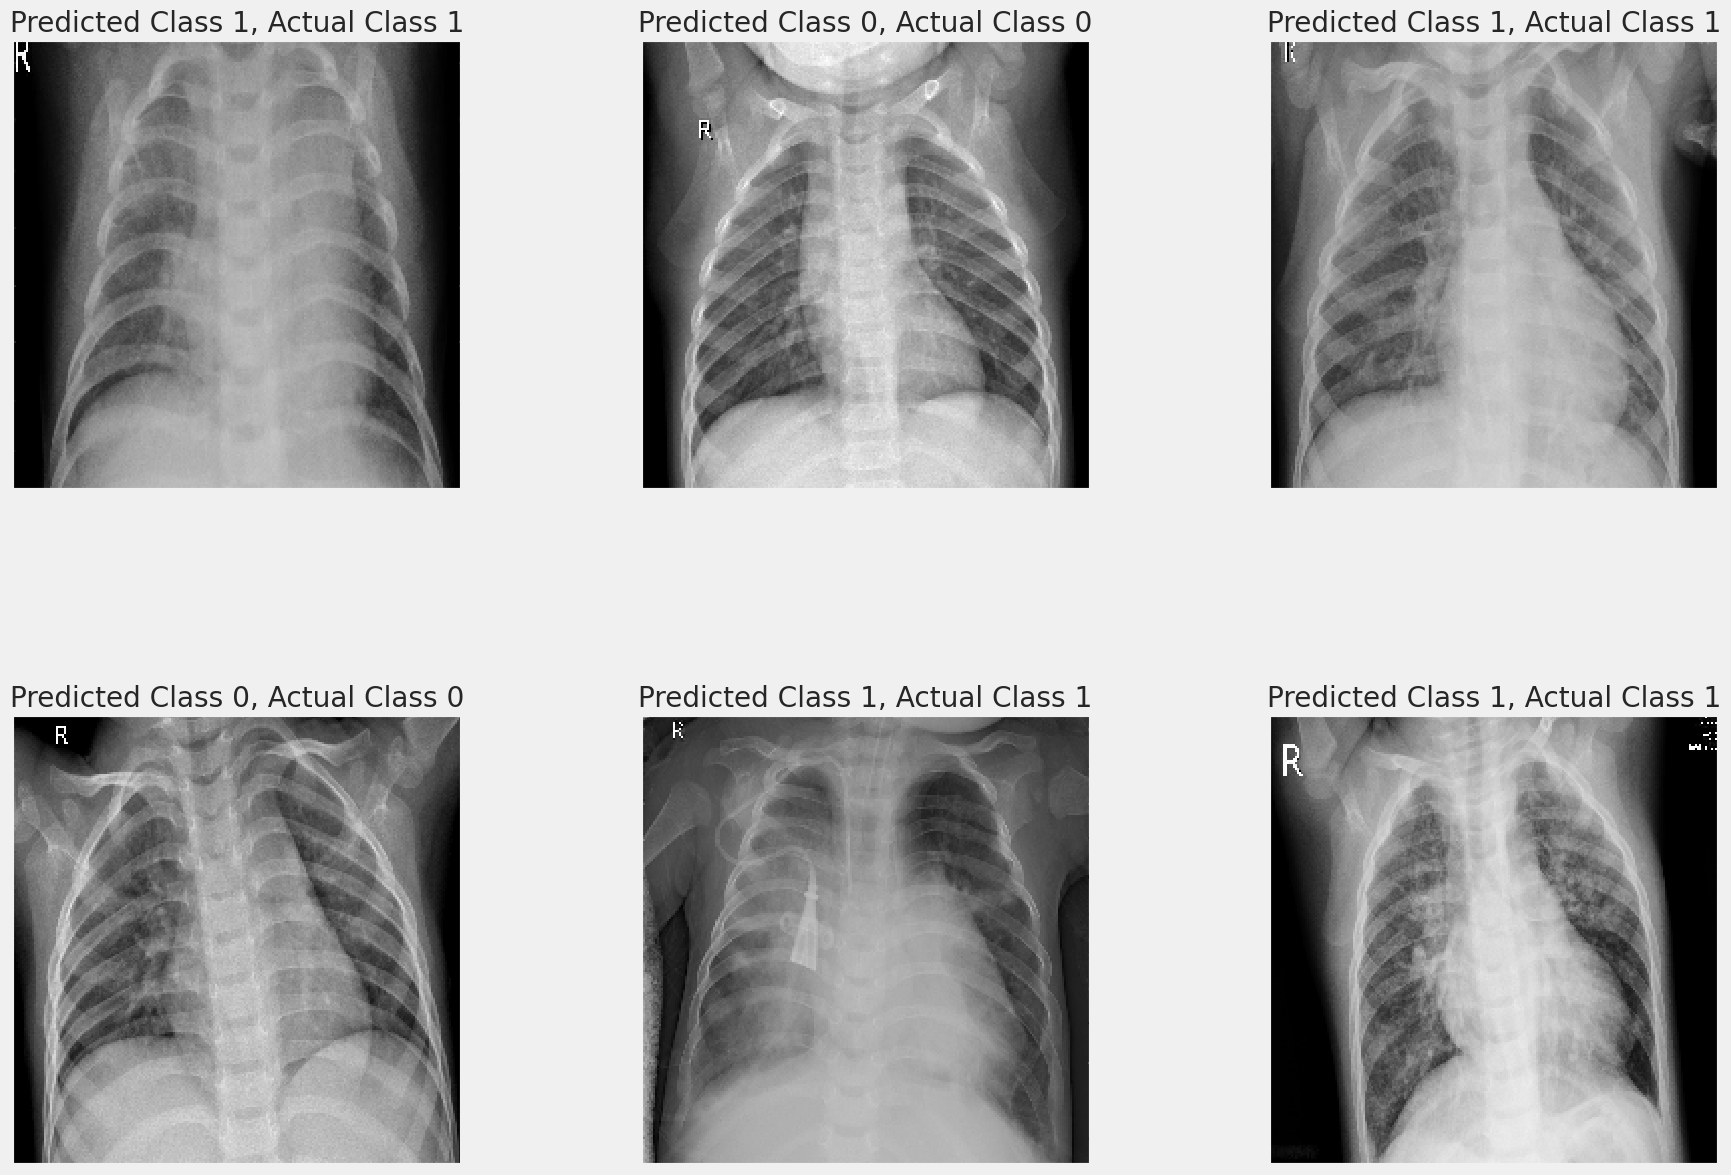

In [ ]:
plt.figure(figsize=(20, 20))  # Increase figure size for larger images
i = 0
for c in correct[:6]:
    plt.subplot(3, 3, i + 1)  # Adjust subplot layout for better spacing
    plt.xticks([])
    plt.yticks([])

    # Get the image from test_gen using the index 'c'
    image, label = test_gen[c // test_gen.batch_size]
    image = image[c % test_gen.batch_size]
    # Reshape if necessary based on your image dimensions
    # Normalize pixel values to the range 0-1
    image = image / 255.0
    plt.imshow(image.reshape(img_size[0], img_size[1], channels),
               cmap="gray", interpolation='none')

    plt.title("Predicted Class {}, Actual Class {}".format(y_pred[c], test_gen.classes[c]))

    i += 1

# Adjust subplot parameters to prevent overlapping titles
plt.subplots_adjust(hspace=0.5, wspace=0.3, top=0.95, bottom=0.05) # Adjust hspace and wspace

plt.show()

Bu kod, modelin yanlış sınıflandırdığı 6 görüntüyü görselleştirir. Her görüntü, doğru ve tahmin edilen etiketleriyle birlikte 3x3 bir ızgarada gösterilir. Görüntüler normalleştirilir ve başlıklar, tahmin ve gerçek sınıflandırmalarla etiketlenir.
Bazı yanlış tahminler:

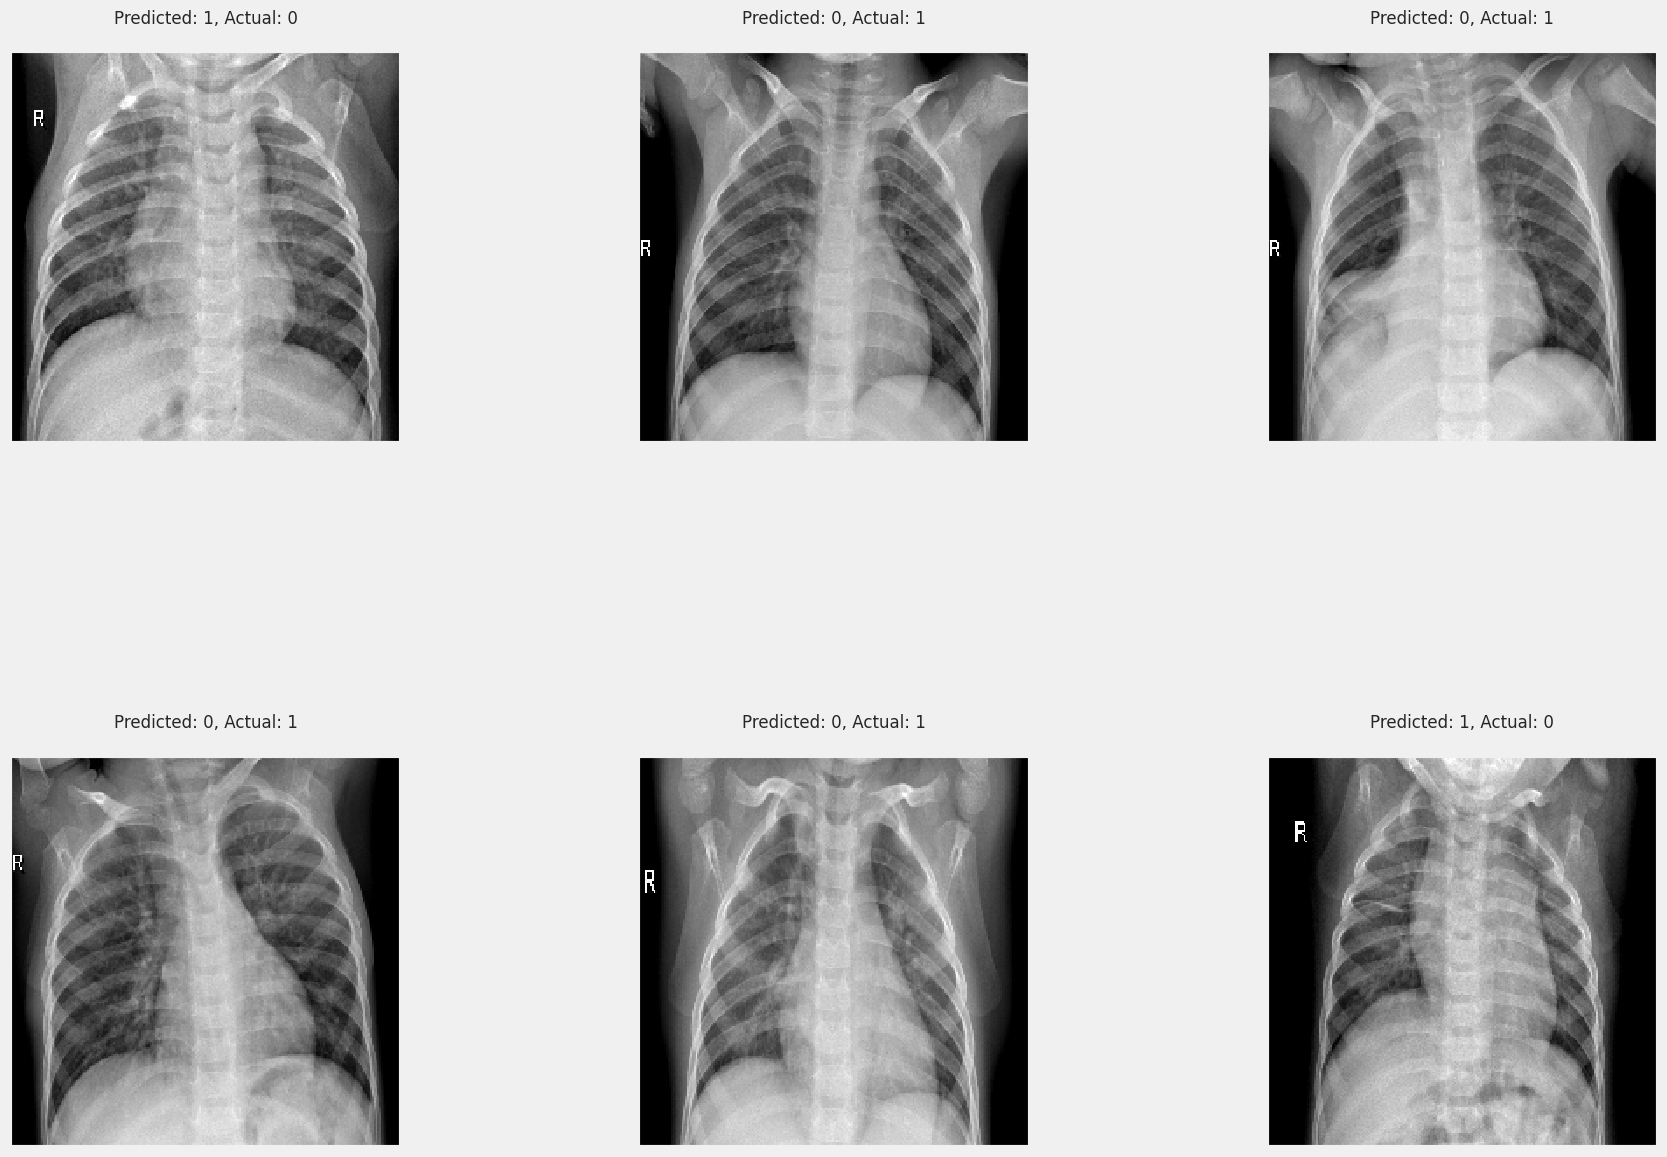

In [ ]:
i = 0
plt.figure(figsize=(20, 20))  # Increase figure size for larger images

for c in incorrect[:6]:
    plt.subplot(3, 3, i + 1)  # Adjust subplot layout for better spacing
    plt.xticks([])
    plt.yticks([])

    # Get the image from test_gen using the index 'c'
    image, label = test_gen[c // test_gen.batch_size]
    image = image[c % test_gen.batch_size]
    # Normalize pixel values to the range 0-1
    image = image / 255.0

    plt.imshow(image.reshape(img_size[0], img_size[1], channels), cmap="gray", interpolation='none')

    # Adjust title position and font size
    plt.title("Predicted: {}, Actual: {}".format(y_pred[c], test_gen.classes[c]),
              fontsize=12, y=1.05)  # Increase y for spacing

    i += 1

# Adjust subplot parameters to prevent overlapping
plt.subplots_adjust(hspace=0.8, wspace=0.3, top=0.95, bottom=0.05)  # Increase hspace

plt.show()

# Model Kayıt

Bu kod, eğitilmiş pnömoni tespiti modelini "Pneumonia Detection.h5" adıyla kaydeder. Modelin yapısı, ağırlıkları ve parametreleri bu dosyada saklanır, böylece tekrar eğitmeye gerek kalmadan yeniden kullanılabilir.

In [ ]:
model.save("Pneumonia Detection.h7")